# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Effecient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [51]:
!pip -q install vit_pytorch linformer

## Import Libraries

In [52]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT


In [53]:
print(f"Torch: {torch.__version__}")

Torch: 1.8.1+cu102


In [54]:
# Training settings
batch_size = 50
epochs = 100
lr = 3e-4
gamma = 0.7
seed = 42

In [55]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [56]:
device = 'cuda'

## Load Data

In [57]:
os.makedirs('../data', exist_ok=True)

In [58]:
train_dir = '../data/train'
test_dir = '../data/test'



In [59]:
# with zipfile.ZipFile('../data/train.zip') as train_zip:
#     train_zip.extractall('data')
    
# with zipfile.ZipFile('../data/test.zip') as test_zip:
#     test_zip.extractall('data')

In [60]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [61]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [62]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Random Plots

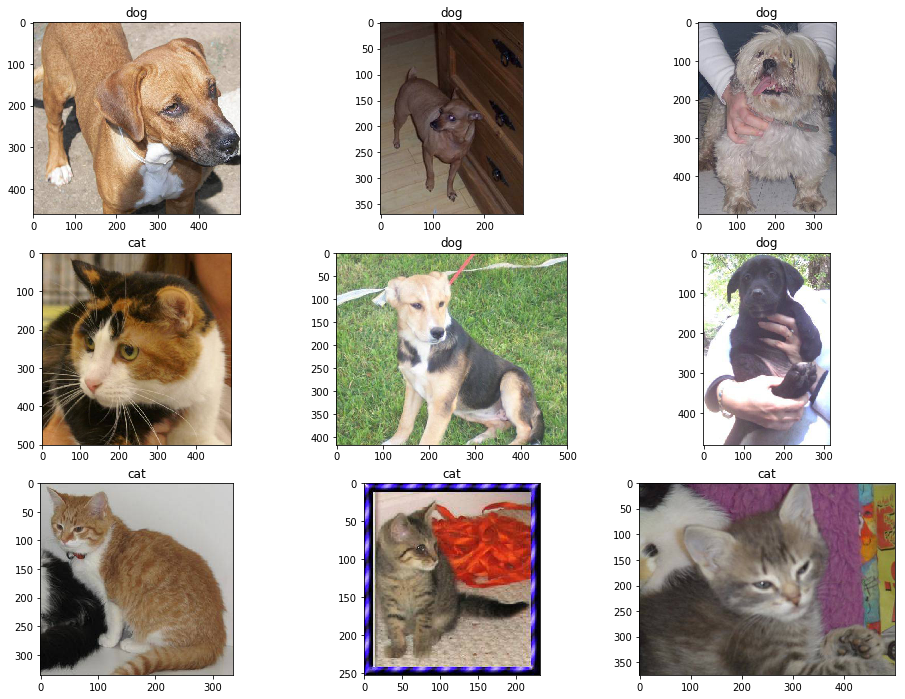

In [63]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [64]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [65]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


## Image Augumentation

In [66]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [67]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label


In [68]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [69]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [70]:
print(len(train_data), len(train_loader))

20000 400


In [71]:
print(len(valid_data), len(valid_loader))

5000 100


## Effecient Attention

### Linformer

In [72]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [73]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

### Training

In [74]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [75]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            #print("label", label)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )



Epoch : 1 - loss : 0.7035 - acc: 0.5124 - val_loss : 0.6981 - val_acc: 0.5238




Epoch : 2 - loss : 0.6820 - acc: 0.5523 - val_loss : 0.6676 - val_acc: 0.5920




Epoch : 3 - loss : 0.6585 - acc: 0.5948 - val_loss : 0.6522 - val_acc: 0.5956




Epoch : 4 - loss : 0.6404 - acc: 0.6199 - val_loss : 0.6284 - val_acc: 0.6486




Epoch : 5 - loss : 0.6228 - acc: 0.6444 - val_loss : 0.6061 - val_acc: 0.6626




Epoch : 6 - loss : 0.6052 - acc: 0.6643 - val_loss : 0.6032 - val_acc: 0.6636




Epoch : 7 - loss : 0.6032 - acc: 0.6707 - val_loss : 0.5955 - val_acc: 0.6828




Epoch : 8 - loss : 0.5920 - acc: 0.6757 - val_loss : 0.5978 - val_acc: 0.6744




Epoch : 9 - loss : 0.5899 - acc: 0.6798 - val_loss : 0.5887 - val_acc: 0.6856




Epoch : 10 - loss : 0.5846 - acc: 0.6844 - val_loss : 0.5907 - val_acc: 0.6798




Epoch : 11 - loss : 0.5800 - acc: 0.6844 - val_loss : 0.5802 - val_acc: 0.6860




Epoch : 12 - loss : 0.5762 - acc: 0.6911 - val_loss : 0.5792 - val_acc: 0.6846




Epoch : 13 - loss : 0.5741 - acc: 0.6960 - val_loss : 0.5849 - val_acc: 0.6816




Epoch : 14 - loss : 0.5733 - acc: 0.6957 - val_loss : 0.5720 - val_acc: 0.6968




Epoch : 15 - loss : 0.5670 - acc: 0.6981 - val_loss : 0.5737 - val_acc: 0.6958




Epoch : 16 - loss : 0.5614 - acc: 0.7037 - val_loss : 0.5708 - val_acc: 0.6972




Epoch : 17 - loss : 0.5586 - acc: 0.7100 - val_loss : 0.5753 - val_acc: 0.7012




Epoch : 18 - loss : 0.5574 - acc: 0.7077 - val_loss : 0.5746 - val_acc: 0.6968




Epoch : 19 - loss : 0.5572 - acc: 0.7085 - val_loss : 0.5613 - val_acc: 0.7054




Epoch : 20 - loss : 0.5507 - acc: 0.7116 - val_loss : 0.5634 - val_acc: 0.7066




Epoch : 21 - loss : 0.5455 - acc: 0.7174 - val_loss : 0.5599 - val_acc: 0.7068




Epoch : 22 - loss : 0.5449 - acc: 0.7196 - val_loss : 0.5589 - val_acc: 0.7094




Epoch : 23 - loss : 0.5435 - acc: 0.7209 - val_loss : 0.5594 - val_acc: 0.7082




Epoch : 24 - loss : 0.5417 - acc: 0.7203 - val_loss : 0.5683 - val_acc: 0.7008




Epoch : 25 - loss : 0.5397 - acc: 0.7240 - val_loss : 0.5673 - val_acc: 0.6944




Epoch : 26 - loss : 0.5398 - acc: 0.7204 - val_loss : 0.5519 - val_acc: 0.7176




Epoch : 27 - loss : 0.5358 - acc: 0.7247 - val_loss : 0.5555 - val_acc: 0.7062




Epoch : 28 - loss : 0.5312 - acc: 0.7290 - val_loss : 0.5565 - val_acc: 0.7072




Epoch : 29 - loss : 0.5290 - acc: 0.7307 - val_loss : 0.5446 - val_acc: 0.7220




Epoch : 30 - loss : 0.5270 - acc: 0.7325 - val_loss : 0.5569 - val_acc: 0.7110




Epoch : 31 - loss : 0.5254 - acc: 0.7341 - val_loss : 0.5489 - val_acc: 0.7198




Epoch : 32 - loss : 0.5243 - acc: 0.7360 - val_loss : 0.5438 - val_acc: 0.7198




Epoch : 33 - loss : 0.5203 - acc: 0.7350 - val_loss : 0.5509 - val_acc: 0.7240




Epoch : 34 - loss : 0.5159 - acc: 0.7388 - val_loss : 0.5303 - val_acc: 0.7334




Epoch : 35 - loss : 0.5190 - acc: 0.7346 - val_loss : 0.5401 - val_acc: 0.7242




Epoch : 36 - loss : 0.5158 - acc: 0.7413 - val_loss : 0.5327 - val_acc: 0.7278




Epoch : 37 - loss : 0.5094 - acc: 0.7454 - val_loss : 0.5314 - val_acc: 0.7364




Epoch : 38 - loss : 0.5076 - acc: 0.7436 - val_loss : 0.5356 - val_acc: 0.7336




Epoch : 39 - loss : 0.5091 - acc: 0.7474 - val_loss : 0.5351 - val_acc: 0.7340




Epoch : 40 - loss : 0.4986 - acc: 0.7529 - val_loss : 0.5303 - val_acc: 0.7238




Epoch : 41 - loss : 0.5022 - acc: 0.7495 - val_loss : 0.5303 - val_acc: 0.7366




Epoch : 42 - loss : 0.4962 - acc: 0.7531 - val_loss : 0.5314 - val_acc: 0.7284




Epoch : 43 - loss : 0.4949 - acc: 0.7540 - val_loss : 0.5312 - val_acc: 0.7338




Epoch : 44 - loss : 0.4942 - acc: 0.7557 - val_loss : 0.5391 - val_acc: 0.7296




Epoch : 45 - loss : 0.4901 - acc: 0.7592 - val_loss : 0.5397 - val_acc: 0.7200




Epoch : 46 - loss : 0.4934 - acc: 0.7582 - val_loss : 0.5164 - val_acc: 0.7460




Epoch : 47 - loss : 0.4899 - acc: 0.7617 - val_loss : 0.5184 - val_acc: 0.7362




Epoch : 48 - loss : 0.4882 - acc: 0.7603 - val_loss : 0.5159 - val_acc: 0.7396




Epoch : 49 - loss : 0.4846 - acc: 0.7633 - val_loss : 0.5136 - val_acc: 0.7360




Epoch : 50 - loss : 0.4858 - acc: 0.7632 - val_loss : 0.5164 - val_acc: 0.7390




Epoch : 51 - loss : 0.4792 - acc: 0.7652 - val_loss : 0.5204 - val_acc: 0.7380




Epoch : 52 - loss : 0.4773 - acc: 0.7687 - val_loss : 0.5220 - val_acc: 0.7376




Epoch : 53 - loss : 0.4823 - acc: 0.7656 - val_loss : 0.5210 - val_acc: 0.7438




Epoch : 54 - loss : 0.4733 - acc: 0.7670 - val_loss : 0.5178 - val_acc: 0.7490




Epoch : 55 - loss : 0.4688 - acc: 0.7772 - val_loss : 0.5116 - val_acc: 0.7450




Epoch : 56 - loss : 0.4701 - acc: 0.7713 - val_loss : 0.4977 - val_acc: 0.7572




Epoch : 57 - loss : 0.4687 - acc: 0.7723 - val_loss : 0.5081 - val_acc: 0.7566




Epoch : 58 - loss : 0.4669 - acc: 0.7740 - val_loss : 0.5044 - val_acc: 0.7550




Epoch : 59 - loss : 0.4640 - acc: 0.7745 - val_loss : 0.5126 - val_acc: 0.7460




Epoch : 60 - loss : 0.4627 - acc: 0.7754 - val_loss : 0.5124 - val_acc: 0.7448




Epoch : 61 - loss : 0.4546 - acc: 0.7811 - val_loss : 0.5087 - val_acc: 0.7560




Epoch : 62 - loss : 0.4595 - acc: 0.7777 - val_loss : 0.4932 - val_acc: 0.7584




Epoch : 63 - loss : 0.4518 - acc: 0.7839 - val_loss : 0.5139 - val_acc: 0.7554




Epoch : 64 - loss : 0.4502 - acc: 0.7855 - val_loss : 0.5023 - val_acc: 0.7494




Epoch : 65 - loss : 0.4498 - acc: 0.7838 - val_loss : 0.5028 - val_acc: 0.7512




Epoch : 66 - loss : 0.4442 - acc: 0.7890 - val_loss : 0.4919 - val_acc: 0.7570




Epoch : 67 - loss : 0.4488 - acc: 0.7834 - val_loss : 0.4831 - val_acc: 0.7662




Epoch : 68 - loss : 0.4460 - acc: 0.7856 - val_loss : 0.5052 - val_acc: 0.7530




Epoch : 69 - loss : 0.4362 - acc: 0.7938 - val_loss : 0.4877 - val_acc: 0.7650




Epoch : 70 - loss : 0.4343 - acc: 0.7944 - val_loss : 0.4875 - val_acc: 0.7618




Epoch : 71 - loss : 0.4360 - acc: 0.7897 - val_loss : 0.4977 - val_acc: 0.7572




Epoch : 72 - loss : 0.4345 - acc: 0.7920 - val_loss : 0.4961 - val_acc: 0.7564




Epoch : 73 - loss : 0.4298 - acc: 0.7949 - val_loss : 0.5013 - val_acc: 0.7670




Epoch : 74 - loss : 0.4259 - acc: 0.8010 - val_loss : 0.4951 - val_acc: 0.7590




Epoch : 75 - loss : 0.4287 - acc: 0.7985 - val_loss : 0.4952 - val_acc: 0.7558




Epoch : 76 - loss : 0.4258 - acc: 0.7985 - val_loss : 0.4866 - val_acc: 0.7650




Epoch : 77 - loss : 0.4216 - acc: 0.8017 - val_loss : 0.4786 - val_acc: 0.7660




Epoch : 78 - loss : 0.4200 - acc: 0.8041 - val_loss : 0.5052 - val_acc: 0.7552




Epoch : 79 - loss : 0.4193 - acc: 0.8031 - val_loss : 0.4991 - val_acc: 0.7618




Epoch : 80 - loss : 0.4143 - acc: 0.8042 - val_loss : 0.4855 - val_acc: 0.7640




Epoch : 81 - loss : 0.4149 - acc: 0.8050 - val_loss : 0.4866 - val_acc: 0.7614




Epoch : 82 - loss : 0.4121 - acc: 0.8087 - val_loss : 0.4897 - val_acc: 0.7630




Epoch : 83 - loss : 0.4083 - acc: 0.8074 - val_loss : 0.4965 - val_acc: 0.7664




Epoch : 84 - loss : 0.4089 - acc: 0.8083 - val_loss : 0.4806 - val_acc: 0.7706




Epoch : 85 - loss : 0.4078 - acc: 0.8091 - val_loss : 0.4754 - val_acc: 0.7694




Epoch : 86 - loss : 0.4015 - acc: 0.8166 - val_loss : 0.4892 - val_acc: 0.7658




Epoch : 87 - loss : 0.4010 - acc: 0.8141 - val_loss : 0.4818 - val_acc: 0.7736




Epoch : 88 - loss : 0.3987 - acc: 0.8158 - val_loss : 0.4663 - val_acc: 0.7798




Epoch : 89 - loss : 0.3974 - acc: 0.8120 - val_loss : 0.4836 - val_acc: 0.7662




Epoch : 90 - loss : 0.3997 - acc: 0.8131 - val_loss : 0.4728 - val_acc: 0.7782




Epoch : 91 - loss : 0.3986 - acc: 0.8138 - val_loss : 0.4794 - val_acc: 0.7706




Epoch : 92 - loss : 0.3938 - acc: 0.8178 - val_loss : 0.4897 - val_acc: 0.7640




Epoch : 93 - loss : 0.3885 - acc: 0.8221 - val_loss : 0.4758 - val_acc: 0.7714




Epoch : 94 - loss : 0.3869 - acc: 0.8193 - val_loss : 0.4685 - val_acc: 0.7782




Epoch : 95 - loss : 0.3858 - acc: 0.8226 - val_loss : 0.4812 - val_acc: 0.7706




Epoch : 96 - loss : 0.3798 - acc: 0.8249 - val_loss : 0.4876 - val_acc: 0.7740




Epoch : 97 - loss : 0.3814 - acc: 0.8241 - val_loss : 0.4748 - val_acc: 0.7758




Epoch : 98 - loss : 0.3822 - acc: 0.8230 - val_loss : 0.4806 - val_acc: 0.7794




Epoch : 99 - loss : 0.3825 - acc: 0.8267 - val_loss : 0.4744 - val_acc: 0.7702




Epoch : 100 - loss : 0.3751 - acc: 0.8286 - val_loss : 0.5015 - val_acc: 0.7640



In [76]:
val_output = model(data)
val_output




tensor([[ 0.6846, -1.2309],
        [ 1.0845, -1.5564],
        [ 0.8094, -1.4422],
        [ 1.0057, -1.4644],
        [-0.3244, -0.3078],
        [-1.2749,  0.8332],
        [ 2.2976, -2.7813],
        [ 0.2944, -0.8818],
        [-1.1632,  0.9035],
        [ 0.5837, -1.1481],
        [ 0.2842, -0.8253],
        [ 2.9585, -3.4093],
        [ 1.4126, -1.9048],
        [-1.7022,  1.0744],
        [ 0.0442, -0.3845],
        [-1.8565,  1.5805],
        [ 0.4516, -1.3869],
        [-1.2006,  0.7371],
        [ 0.2016, -0.5590],
        [ 0.0912, -0.6376],
        [-0.5562, -0.0349],
        [ 0.4176, -1.0077],
        [-0.5298,  0.0587],
        [-0.1949, -0.5467],
        [-2.0178,  1.7522],
        [ 0.7021, -1.3491],
        [ 0.5037, -1.1592],
        [-0.3354, -0.3281],
        [-1.2269,  1.0249],
        [-0.2208, -0.0952],
        [-0.6527,  0.1511],
        [-1.0292,  0.6034],
        [-0.9317,  0.3443],
        [-0.9873,  0.6717],
        [-1.7576,  1.4874],
        [ 0.3121, -0

In [77]:
test_data[0][1]

0

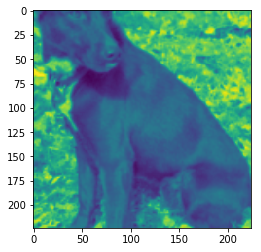

1
prediction tensor([0], device='cuda:0')


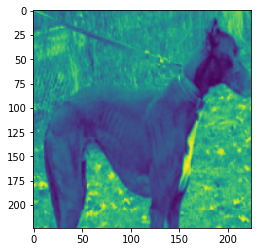

1
prediction tensor([1], device='cuda:0')


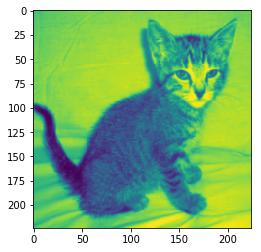

0
prediction tensor([0], device='cuda:0')


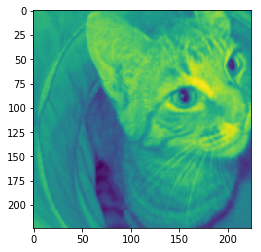

0
prediction tensor([0], device='cuda:0')


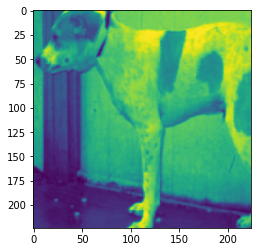

1
prediction tensor([1], device='cuda:0')


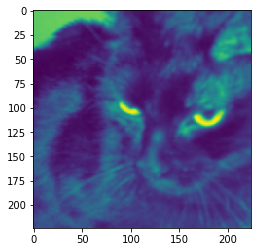

0
prediction tensor([0], device='cuda:0')


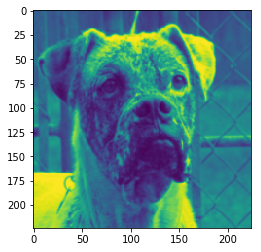

1
prediction tensor([1], device='cuda:0')


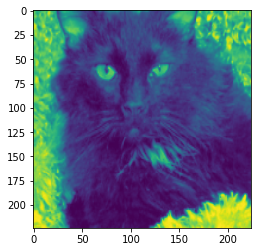

0
prediction tensor([0], device='cuda:0')


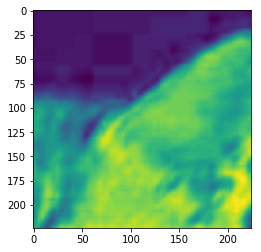

0
prediction tensor([0], device='cuda:0')


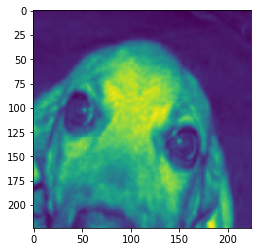

1
prediction tensor([1], device='cuda:0')


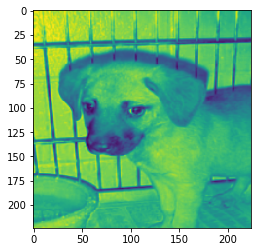

1
prediction tensor([1], device='cuda:0')


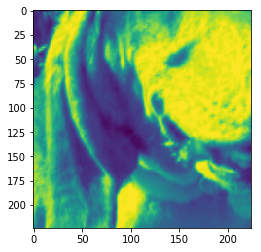

1
prediction tensor([1], device='cuda:0')


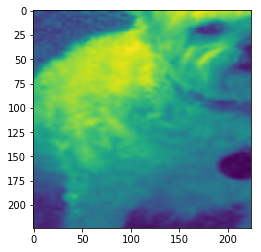

1
prediction tensor([0], device='cuda:0')


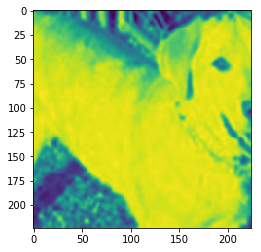

1
prediction tensor([0], device='cuda:0')


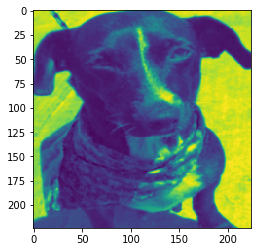

1
prediction tensor([1], device='cuda:0')


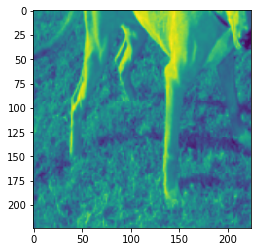

1
prediction tensor([1], device='cuda:0')


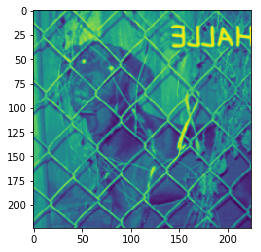

1
prediction tensor([0], device='cuda:0')


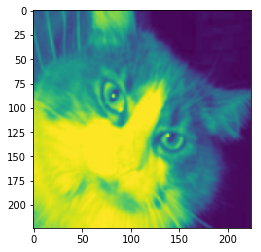

0
prediction tensor([0], device='cuda:0')


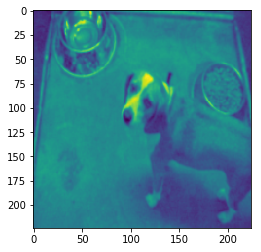

1
prediction tensor([1], device='cuda:0')


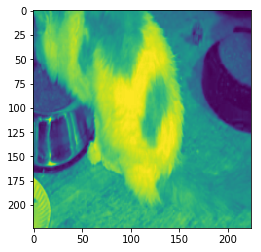

0
prediction tensor([0], device='cuda:0')


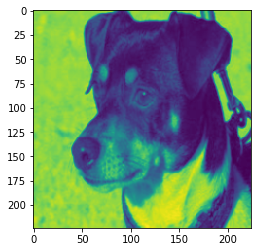

1
prediction tensor([1], device='cuda:0')


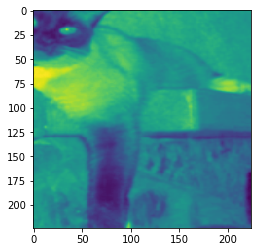

0
prediction tensor([1], device='cuda:0')


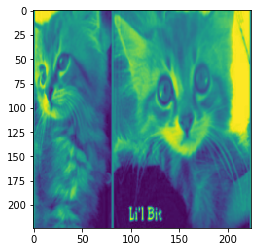

0
prediction tensor([1], device='cuda:0')


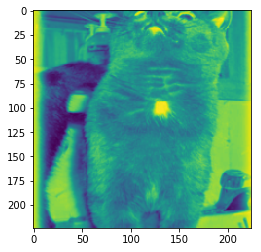

0
prediction tensor([0], device='cuda:0')


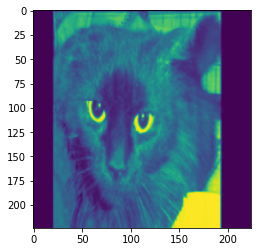

0
prediction tensor([0], device='cuda:0')


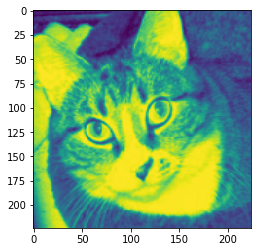

0
prediction tensor([0], device='cuda:0')


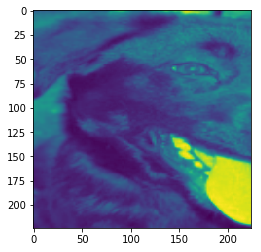

1
prediction tensor([1], device='cuda:0')


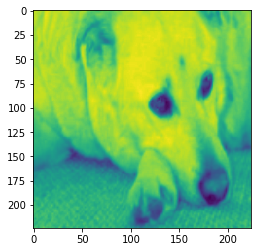

1
prediction tensor([1], device='cuda:0')


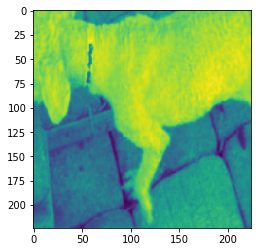

1
prediction tensor([0], device='cuda:0')


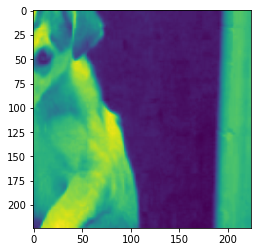

1
prediction tensor([1], device='cuda:0')


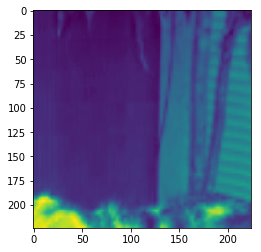

0
prediction tensor([1], device='cuda:0')


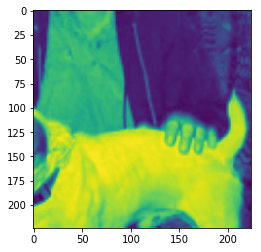

1
prediction tensor([0], device='cuda:0')


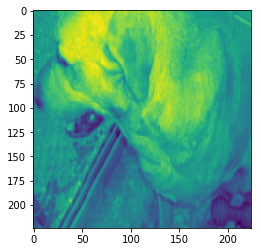

1
prediction tensor([0], device='cuda:0')


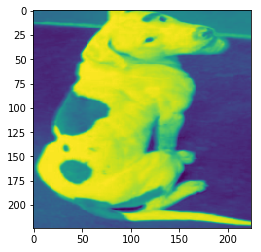

1
prediction tensor([0], device='cuda:0')


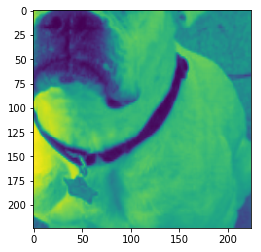

1
prediction tensor([1], device='cuda:0')


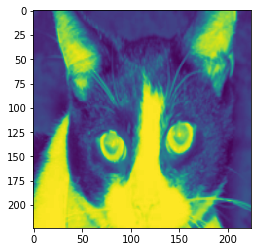

0
prediction tensor([0], device='cuda:0')


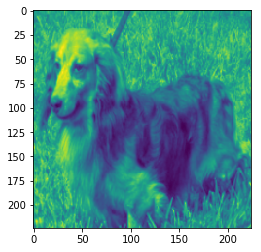

1
prediction tensor([1], device='cuda:0')


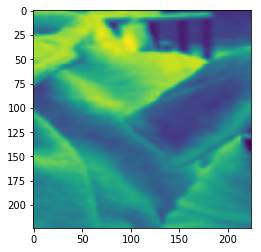

1
prediction tensor([1], device='cuda:0')


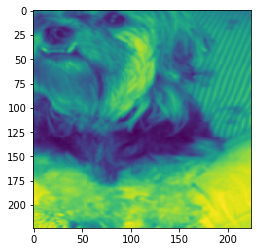

1
prediction tensor([1], device='cuda:0')


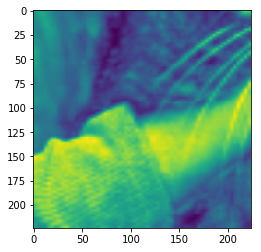

0
prediction tensor([0], device='cuda:0')


In [79]:
for idx in range(40):
    #img = Image.open(data[idx].cpu())
#     ax.set_title(labels[idx])
#     ax.imshow(test_data[idx])
    plt.imshow(valid_data[idx][0][0])
    #plt.title("label:", test_data[idx][1])
    plt.show()
    print(valid_data[idx][1])
    prediction_latent = model(valid_data[idx][0].unsqueeze(0).cuda())
    
    print("prediction", prediction_latent.argmax(dim=1))
    #print(valid_data[idx][0].shape)